In [1]:
import pandas as pd
import numpy as np
from env import get_db_url
import wrangle_zillow
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
df = wrangle_zillow.wrangle_zillow()

Using cached data


In [3]:
df = wrangle_zillow.handle_missing_zillow_values(df)

For threshold based dropping: 
(52463, 61)  original shape
(52463, 59)  shape after dropping columns with prop required rows below theshold
(52463, 59)  shape after dropping rows with prop required columns below threshold


In [4]:
df.shape

(50906, 53)

In [5]:
df.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county'],
      dtype='o

### Ask at least 5 questions about the data. Target is logerror
- Is log error significantly different for properties in different counties?
    - ANOVA and/or T-test
    - If assumptions can't be met, Kruskal-Wallis H-test (non-parametric ANOVA)
- How does log error change with square footage?
    - Correlation test
- Holding bedroom count constant, how does number of bathrooms correlate with logerro?
    - Correlation test
- Do houses with garages have log errors above or below those without?
    - T-test
- Does number of garages correlate with higher log error?
    - Correlation test



### Split data

In [6]:
train, validate, test = wrangle_zillow.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [7]:
train.shape, validate.shape, test.shape

((28506, 53), (12218, 53), (10182, 53))

In [162]:
train.roomcnt.value_counts()

0.0     20463
6.0      2239
7.0      1996
8.0      1553
5.0      1020
9.0       638
4.0       285
10.0      188
11.0       54
3.0        39
12.0       15
2.0         6
13.0        5
14.0        4
1.0         1
Name: roomcnt, dtype: int64

In [163]:
train[train.roomcnt>0].roomcnt.quantile(0.75)

8.0

In [161]:
train[train.roomcnt>0].roomcnt.quantile(0.25)

6.0

### Add additional features

In [62]:
pd.qcut(train.bedroom, 3).value_counts()

(-0.001, 3.0]    17768
(3.0, 4.0]        8212
(4.0, 10.0]       2526
Name: bedroom, dtype: int64

In [170]:
train['age'] = 2017 - train.yearbuilt
train['bathroom_bin'] = pd.qcut(train.bathroom, 2, labels=["less_than_2","2_or_more"])
train['bedroom_bin'] = pd.qcut(train.bedroom, 3, labels = ["less_than_3","3","4_or_more"])
train['age_bin']=pd.qcut(train.age, 2, labels=['young','old'])
train['has_garage'] = train.garage>0
train['home_size'] = pd.qcut(train.square_feet,3, labels=['small','medium','large'])
train['living_space'] = train.square_feet - (40*train.bathroom+200*train.bedroom)
train['tax_rate'] = train.taxamount/train.tax_value
train['acres'] = train.lot_size/43560
train['strucutre_dollar_per_sqft'] = train.tax_value/train.square_feet
train['land_dollar_per_sqft'] = train.landtaxvaluedollarcnt / train.square_feet
train['bed_bath_ratio'] = train.bedroom/train.bathroom
train['is_la'] = train.county == 'Los Angeles County'

In [165]:
# No values show any significant correlation with logerror right off the bat
train.corrwith(train.logerror).sort_values(ascending=False)

logerror                      1.000000
square_feet                   0.037065
bedroom                       0.035942
living_space                  0.033667
bathroom                      0.033103
longitude                     0.031609
fullbathcnt                   0.027727
garagetotalsqft               0.025861
threequarterbathnbr           0.025033
garage                        0.024972
yearbuilt                     0.024653
has_garage                    0.024393
roomcnt                       0.017508
numberofstories               0.016922
parcelid                      0.010579
basementsqft                  0.008946
lot_size                      0.008641
regionidcity                  0.007473
fips                          0.005011
rawcensustractandblock        0.004938
censustractandblock           0.004936
taxdelinquencyyear            0.004370
tax_rate                      0.003634
id                            0.003312
structuretaxvaluedollarcnt    0.003165
zip                      

In [137]:
overall_mean = train.logerror.mean()
print(f"Overall mean logerror: {overall_mean}")
for col in train.columns:
    if train[col].nunique()<10:
        for option in train[col].unique():
            if len(train[train[col]==option].logerror)>2:
                t, p = stats.ttest_1samp(train[train[col]==option].logerror, train.logerror.mean())
                if p<alpha:
                    sample_mean = train[train[col]==option].logerror.mean()
                    difference = sample_mean - overall_mean
                    print(f"For {col} - {option} the mean ({sample_mean:.4f}) differs significantly from overall mean by {difference:.4f}, sample size {len(train[train[col]==option].logerror)}")

Overall mean logerror: 0.018113638023293778
For fips - 6037.0 the mean (0.0148) differs significantly from overall mean by -0.0033, sample size 18412
For fips - 6059.0 the mean (0.0280) differs significantly from overall mean by 0.0099, sample size 7668
For fireplacecnt - 1.0 the mean (0.0116) differs significantly from overall mean by -0.0065, sample size 3359
For pools - 1.0 the mean (0.0121) differs significantly from overall mean by -0.0060, sample size 6005
For pooltypeid7 - 1.0 the mean (0.0113) differs significantly from overall mean by -0.0068, sample size 5456
For regionidcounty - 3101.0 the mean (0.0148) differs significantly from overall mean by -0.0033, sample size 18412
For regionidcounty - 1286.0 the mean (0.0280) differs significantly from overall mean by 0.0099, sample size 7668
For threequarterbathnbr - 1.0 the mean (0.0296) differs significantly from overall mean by 0.0115, sample size 3614
For unitcnt - None the mean (0.0241) differs significantly from overall mean b

### Based on t-test results the highest positive error differences were with:
    - bedroom bin - 4 or more
    - threequarterbathnbr - 1.0
    - Orange county
    - heatingsystem - Not specified

### Highest negative error differences:
   - solar heat


### Is log error significantly different for properties in different counties?
- ANOVA and/or T-test

In [64]:
ventura_properties = train[train.county == 'Ventura County'].logerror
la_properties = train[train.county == 'Los Angeles County'].logerror
orange_properties = train[train.county == 'Orange County'].logerror

- $H_0$: log error means are all equal between each county
- $H_a$: means are not equal to each other

In [65]:
alpha = 0.05

In [66]:
ventura_properties.var(), la_properties.var(), orange_properties.var()

(0.02640727357180353, 0.02601732494807998, 0.04287695019874075)

In [67]:
stats.levene(ventura_properties, la_properties, orange_properties)

LeveneResult(statistic=14.350513208349438, pvalue=5.899117144829073e-07)

In [68]:
# Variances are unequal
# Greater than 30 samples, approximately normal distribution

In [69]:
f, p = stats.kruskal(ventura_properties, la_properties, orange_properties)

In [70]:
print("Can reject null hypothesis, there is a difference between the population medians: ", p<alpha)

Can reject null hypothesis, there is a difference between the population medians:  True


In [105]:
county_data = {'ventura': ventura_properties.median(),
        'la': la_properties.median(),
        'orange': orange_properties.median()}

plt.figure(figsize=(16,8))
plt.bar(county_data.keys(), county_data.values())
plt.xlabel('county')
plt.ylabel('median log error')
plt.axhline(train.logerror.median(),color='r')
plt.title("Median Log Error by County. Red Line Shows Median for all Properties")

### Can conclude that there is a significantly different between the population medians.

In [73]:
t, p = stats.ttest_ind(orange_properties, la_properties, equal_var=False)
print("Orange and LA logerror means differ significantly: ",p<alpha)

Orange and LA logerror means differ significantly:  True


In [74]:
t, p = stats.ttest_ind(orange_properties, ventura_properties, equal_var=False)
print("Orange and Ventura logerror means differ significantly: ",p<alpha)

Orange and Ventura logerror means differ significantly:  True


In [75]:
t, p = stats.ttest_ind(ventura_properties, la_properties, equal_var=False)
print("Ventura and LA logerror means differ significantly: ",p<alpha)

Ventura and LA logerror means differ significantly:  False


### Ventura and LA are fairly close (not significantly different) while Orange is significantly different from the other two counties in terms of mean log error.

In [76]:
county_train = pd.get_dummies(train, columns = ['county'],prefix = 'is')

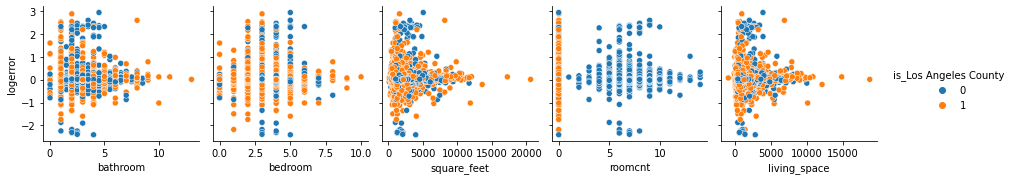

In [77]:
sns.pairplot(x_vars=['bathroom','bedroom','square_feet','roomcnt', 'living_space'], y_vars='logerror', data=county_train, hue='is_Los Angeles County')

## Looking at roomcnt vs logerror  - doesn't look like any data for LA county but for the other counties there appear to be some high and lower clusters of log error

In [78]:
not_la = county_train[county_train["is_Los Angeles County"]==0]

<AxesSubplot:xlabel='roomcnt', ylabel='logerror'>

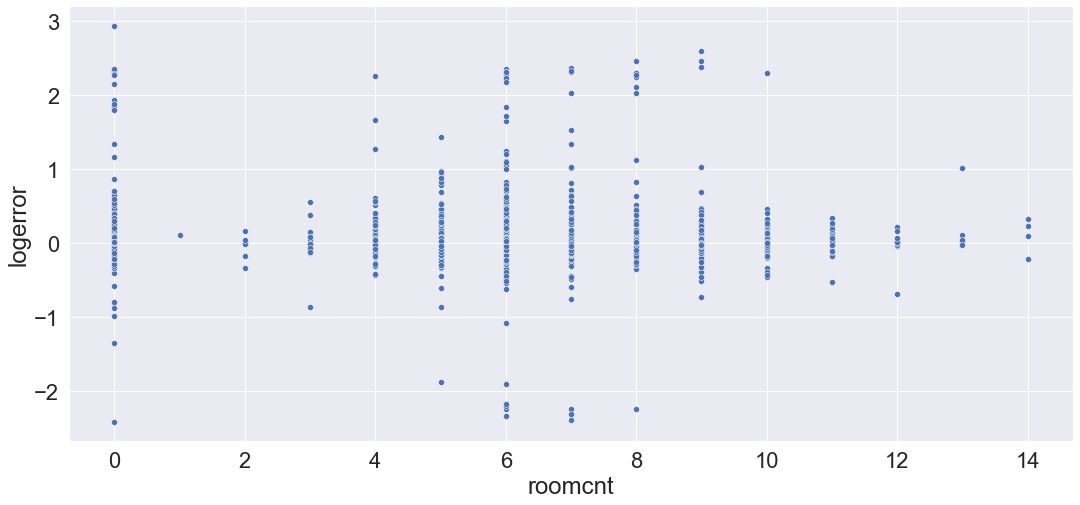

In [122]:
sns.set(font_scale = 2)
plt.figure(figsize=(18,8))
sns.scatterplot(data = not_la, x='roomcnt', y = 'logerror')

<AxesSubplot:xlabel='roomcnt', ylabel='logerror'>

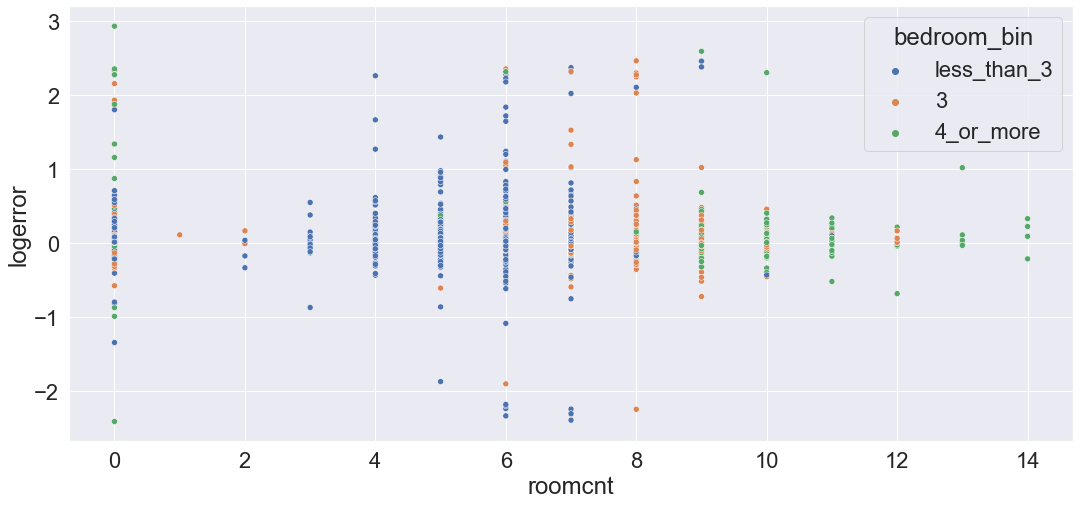

In [125]:
plt.figure(figsize=(18,8))
sns.scatterplot(data = not_la, x='roomcnt', y = 'logerror', hue = 'bedroom_bin')

### Can't find other features to explain the higher and lower clusters of logerror

In [80]:
train.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

## How does log error change with square footage

In [91]:
r, p = stats.pearsonr(train.square_feet, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.03706545213660601 is significant: True
This is a very weak correlation


<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

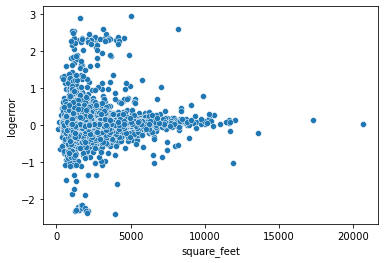

In [92]:
sns.scatterplot(data = train, x = 'square_feet', y = 'logerror')

### Essentially no linear correlation between log error and square footage

In [95]:
# Same with living space
r, p = stats.pearsonr(train.living_space, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.033667425259480355 is significant: True
This is a very weak correlation


### Holding bedroom count constant, how does number of bathrooms correlate with logerror?
- Correlation test

In [83]:
print("Log error to Bathroom count correlation, holding bedroom count constant")
print("------")
for bed in train.bedroom.unique():
    bedroom_sample = train[train.bedroom == bed]
    # Check if actually values in the sample to allow for correlation test
    if len(bedroom_sample)>1:
        r, p = stats.pearsonr(bedroom_sample.bathroom, bedroom_sample.logerror)
        print(f"For {bed} bedrooms, correlation of {r} is significant: {p<alpha}")
        if p<alpha:
            if r<0.3 and r>-0.3:
                print("This is a very weak correlation")

Log error to Bathroom count correlation, holding bedroom count constant
------
For 3.0 bedrooms, correlation of 0.003109047143655637 is significant: False
For 2.0 bedrooms, correlation of -0.01219495122231834 is significant: False
For 4.0 bedrooms, correlation of 0.017800492914307804 is significant: False
For 5.0 bedrooms, correlation of 0.060361772246668416 is significant: True
This is a very weak correlation
For 1.0 bedrooms, correlation of -0.05460323208145078 is significant: False
For 6.0 bedrooms, correlation of 0.05866005673103777 is significant: False
For 7.0 bedrooms, correlation of -0.22176309517539067 is significant: False
For 8.0 bedrooms, correlation of 0.2924469401706446 is significant: False
For 0.0 bedrooms, correlation of -0.1272152908576515 is significant: False
For 9.0 bedrooms, correlation of -0.8528553929073035 is significant: False


<AxesSubplot:xlabel='bathroom', ylabel='logerror'>

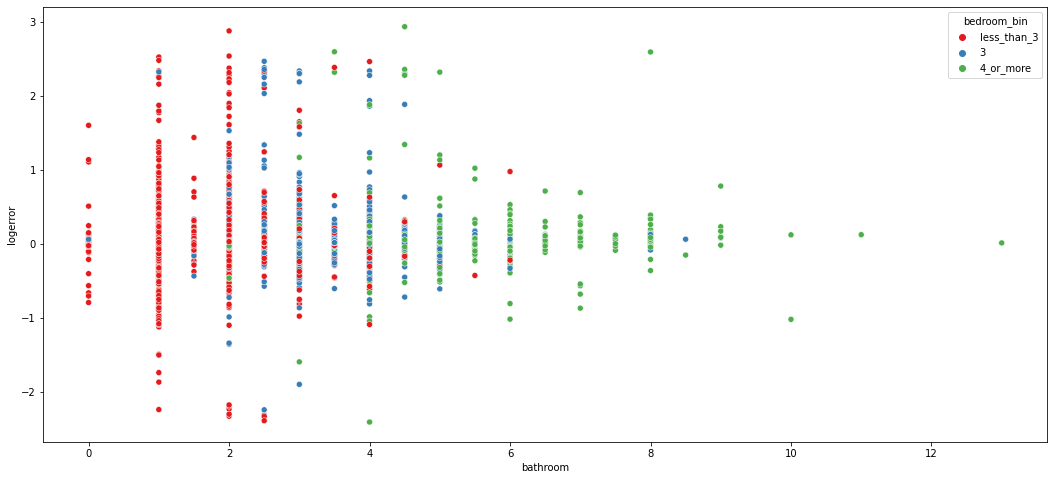

In [90]:
plt.figure(figsize=(18,8))
sns.scatterplot(data = train, hue = 'bedroom_bin', x='bathroom', y='logerror', palette='Set1')

### No correlation between bathroom count and logerror

## What about bedroom count?

In [138]:
r, p = stats.pearsonr(train.bedroom, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.035941868337811586 is significant: True
This is a very weak correlation


In [152]:
bedroom_data[bed_bin] == train[train.bedroom_bin == bed_bin].logerror.mean()

False

Text(0.5, 1.0, 'Median Log Error by Bedroom Count. Red Line Shows Median for all Properties')

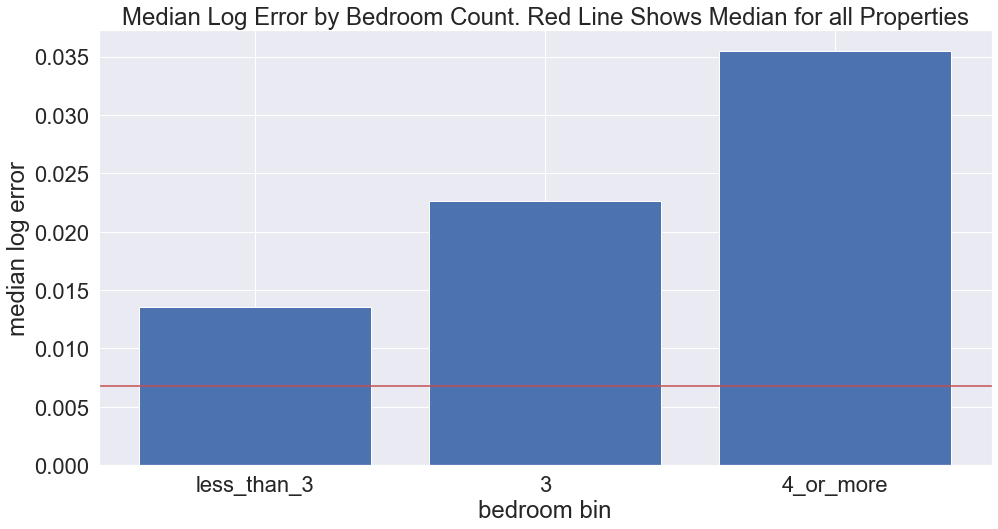

In [154]:
bedroom_data = {k:0 for k in train.bedroom_bin.unique()}
for bed_bin in train.bedroom_bin.unique():
    
    bedroom_data[bed_bin] = train[train.bedroom_bin == bed_bin].logerror.mean()


plt.figure(figsize=(16,8))
plt.bar(bedroom_data.keys(), bedroom_data.values())
plt.xlabel('bedroom bin')
plt.ylabel('median log error')
plt.axhline(train.logerror.median(),color='r')
plt.title("Median Log Error by Bedroom Count. Red Line Shows Median for all Properties")

## Do houses with garages have log errors above or below those without?
    - T-test - will do two sample t-test, 1 tail. Check if with garage has greater error than without garage

In [119]:
with_garage = train[train.has_garage].logerror
without_garage = train[~train.has_garage].logerror

In [121]:
with_garage.var(), without_garage.var()

(0.03739316995581872, 0.02704537746190941)

In [122]:
stats.levene(with_garage, without_garage)

LeveneResult(statistic=38.8499878991891, pvalue=4.6406239350179917e-10)

In [ ]:
# Unequal variances


<BarContainer object of 2 artists>

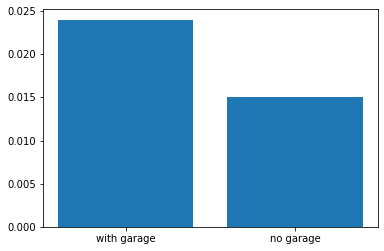

In [124]:
plt.bar(['with garage', 'no garage'],[with_garage.mean(), without_garage.mean()])

In [128]:
t,p = stats.ttest_ind(with_garage, without_garage, equal_var=False)
if (t>0) and (p/2<alpha):
    print("Reject null: mean of logerror for with garage is greater than for those without garage")

Reject null: mean of logerror for with garage is greater than for those without garage


### Does number of garages correlate with higher log error?
- Correlation test

<AxesSubplot:xlabel='garage', ylabel='logerror'>

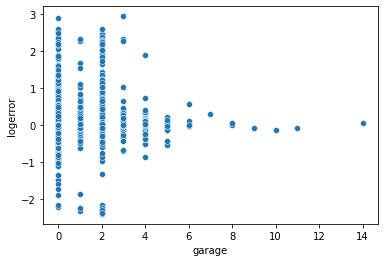

In [131]:
sns.scatterplot(data = train, x = 'garage', y = 'logerror')

In [133]:
r, p = stats.pearsonr(train.square_feet, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.03706545213660601 is significant: True
This is a very weak correlation


### very weak correlation between number of garages and logerror

In [159]:
train.numberofstories.value_counts()

0.0    20501
1.0     4843
2.0     2973
3.0      189
Name: numberofstories, dtype: int64

<AxesSubplot:xlabel='numberofstories', ylabel='logerror'>

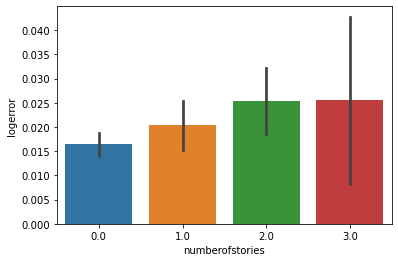

In [161]:
sns.barplot(data = train, x='numberofstories',y='logerror')

### Maybe a small difference depending on number of stories

In [174]:
train.airconditioningdesc.value_counts()

Not Specified    21247
Central           6302
Yes                874
None                73
Wall Unit           10
Name: airconditioningdesc, dtype: int64

<AxesSubplot:xlabel='airconditioningdesc', ylabel='logerror'>

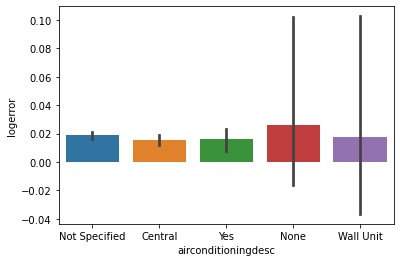

In [175]:
sns.barplot(data = train, x='airconditioningdesc',y='logerror')

### Nothing significant looking for air conditioning

In [177]:
train["age"] = 2017 - train.yearbuilt

<AxesSubplot:xlabel='age', ylabel='logerror'>

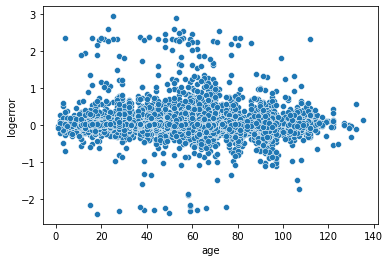

In [180]:
sns.scatterplot(data = train, x='age', y = 'logerror')

### nothing significant looking for age

## regionidcity?

In [262]:
def is_error_above_threshold(regionidcity, threshold):
    return (train.groupby('regionidcity').logerror.agg('mean')>threshold).loc[regionidcity]

In [264]:
train["logerror_above_threshold"]=train.apply(lambda row: is_error_above_threshold(row.regionidcity, 0.1), axis=1)

In [266]:
train[train.logerror_above_threshold].regionidcity.value_counts()

118994.0    39
36502.0     22
25468.0     16
32753.0      6
3491.0       4
13311.0      2
Name: regionidcity, dtype: int64

<AxesSubplot:xlabel='regionidcity', ylabel='logerror'>

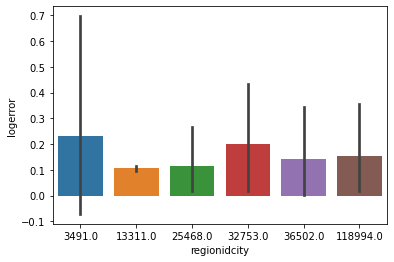

In [267]:
sns.barplot(data = train[train.logerror_above_threshold],  x='regionidcity',y='logerror')

### These 6 regionidcities have greater average logerrors, need to check for significance

In [287]:
regionidcitymeans=[]
ps=[]
num_samples=[]
cities = []
for city in train.regionidcity.unique():
    regionidcitymean = train[train.regionidcity == city].logerror.mean()
    t, p = stats.ttest_1samp(train[train.regionidcity == city].logerror, train.logerror.mean())
    if p<alpha:
        print(city, "City's mean logerror: ",round(regionidcitymean,4), "vs average", 
              round(train.logerror.mean(),4), "Significant?",p<alpha,
             ",number of samples: ",len(train[train.regionidcity == city]))
    regionidcitymeans.append(regionidcitymean)
    ps.append(p)
    num_samples.append(len(train[train.regionidcity == city]))
    cities.append(city)

results = pd.DataFrame(data = {'city':cities,'city_mean':regionidcitymeans, 'p_value':ps, 'number_of_samples':num_samples})
results["significant"]=results.p_value<0.05
results["overall_mean"] = train.logerror.mean()
results["city_vs_overall"] = results.city_mean - results.overall_mean

12447.0 City's mean logerror:  0.0073 vs average 0.0181 Significant? True ,number of samples:  6361
33612.0 City's mean logerror:  -0.0085 vs average 0.0181 Significant? True ,number of samples:  149
46298.0 City's mean logerror:  0.0059 vs average 0.0181 Significant? True ,number of samples:  808
29189.0 City's mean logerror:  -0.0178 vs average 0.0181 Significant? True ,number of samples:  55
10241.0 City's mean logerror:  0.0408 vs average 0.0181 Significant? True ,number of samples:  80
52650.0 City's mean logerror:  0.0421 vs average 0.0181 Significant? True ,number of samples:  414
19177.0 City's mean logerror:  -0.0157 vs average 0.0181 Significant? True ,number of samples:  153
27110.0 City's mean logerror:  0.009 vs average 0.0181 Significant? True ,number of samples:  477
25974.0 City's mean logerror:  0.0092 vs average 0.0181 Significant? True ,number of samples:  139
5465.0 City's mean logerror:  0.0001 vs average 0.0181 Significant? True ,number of samples:  114
26483.0 Ci

In [288]:
# These are the results that are significant. Highest mean city logerror is 0.08
results[results.significant].sort_values('city_mean', ascending=False).head(10)

,city,city_mean,p_value,number_of_samples,significant,overall_mean,city_vs_overall
156,42091.0,0.080233,0.026085,17,True,0.018114,0.062119
168,25621.0,0.075716,0.045891,4,True,0.018114,0.057602
86,26483.0,0.057609,0.006247,124,True,0.018114,0.039495
33,52650.0,0.042143,0.048804,414,True,0.018114,0.024029
25,10241.0,0.040828,0.048283,80,True,0.018114,0.022714
55,25974.0,0.009160,0.019326,139,True,0.018114,-0.008954
43,27110.0,0.008972,0.005105,477,True,0.018114,-0.009142
104,37086.0,0.008400,0.034839,91,True,0.018114,-0.009713
2,12447.0,0.007315,0.000001,6361,True,0.018114,-0.010798
18,46298.0,0.005876,0.010239,808,True,0.018114,-0.012238


## Perhaps these cities are worth putting as their own group (categorical) as they exhibit significant differences from overall mean

In [289]:
train.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'has_garage', '

<AxesSubplot:xlabel='age_bin', ylabel='logerror'>

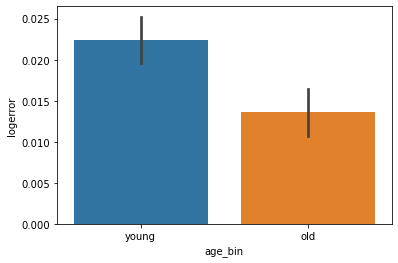

In [305]:
sns.barplot(data = train,  x='age_bin',y='logerror')

## Younger homes exhibit greater logerror

In [310]:
young_homes = train[train.age_bin=='young'].logerror
old_homes = train[train.age_bin=='old'].logerror

In [311]:
stats.levene(young_homes,old_homes)

LeveneResult(statistic=138.73372556932893, pvalue=5.973850727902967e-32)

In [312]:
stats.ttest_ind(young_homes, old_homes, equal_var=False)

Ttest_indResult(statistic=4.196380034519133, pvalue=2.7204573257639104e-05)

Significant difference between young and old homes

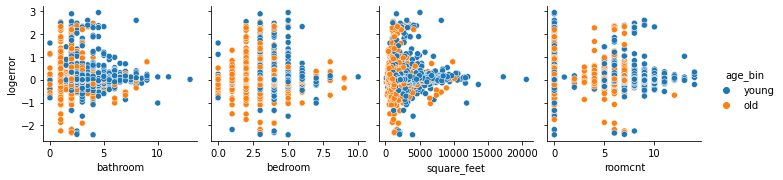

In [314]:
sns.pairplot(x_vars=['bathroom','bedroom','square_feet','roomcnt'], y_vars='logerror', data=train, hue='age_bin')

### Maybe cluster between low and high bathrooms?

In [319]:
train['bathroom_bin'] = pd.qcut(train.bathroom, 2, labels=["less_than_2","2_or_more"])

<AxesSubplot:xlabel='bathroom_bin', ylabel='logerror'>

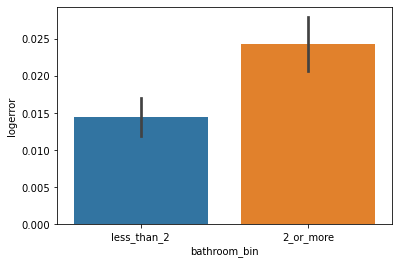

In [320]:
sns.barplot(data = train,  x='bathroom_bin',y='logerror')

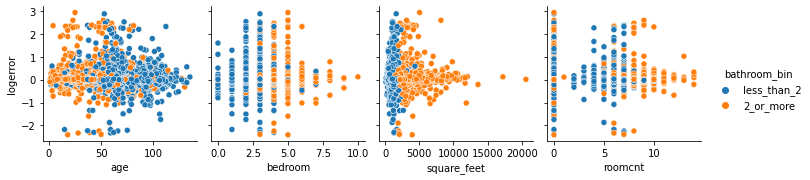

In [321]:
sns.pairplot(x_vars=['age','bedroom','square_feet','roomcnt'], y_vars='logerror', data=train, hue='bathroom_bin')

### Younger homes and 2 or greater bathrooms seem to be one cluster

In [322]:
train.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'has_garage', '

### BONUS: Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [281]:
zipmeans=[]
ps=[]
num_samples=[]
for zipcode in train.zip.unique():
    zipmean = train[train.zip == zipcode].logerror.mean()
    t, p = stats.ttest_1samp(train[train.zip == zipcode].logerror, train.logerror.mean())
    # if p<alpha:
    #     print(zipcode, "Zip's mean logerror: ",round(zipmean,4), "vs average", 
    #           round(train.logerror.mean(),4), "Significant?",p<alpha,
    #          ",number of samples: ",len(train[train.zip == zipcode]))
    zipmeans.append(zipmean)
    ps.append(p)
    num_samples.append(len(train[train.zip == zipcode]))

results = pd.DataFrame(data = {'zip_mean':zipmeans, 'p_value':ps, 'number_of_samples':num_samples})
results["significant"]=results.p_value<0.05
results["overall_mean"] = train.logerror.mean()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [282]:
results

,zip_mean,p_value,number_of_samples,significant,overall_mean
0,-0.004726,0.249090,143,False,0.018114
1,0.022269,0.634388,264,False,0.018114
2,0.002773,0.405280,57,False,0.018114
3,-0.031005,0.086056,55,False,0.018114
4,-0.009468,0.063303,76,False,0.018114
...,...,...,...,...,...
371,-0.080375,0.395027,3,False,0.018114
372,0.067098,NaN,1,False,0.018114
373,0.049831,0.851520,2,False,0.018114
374,0.063920,NaN,1,False,0.018114
